# 1. Libraries

In [68]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# 2. Load data

In [28]:
column_names = ['unit', 'cycle', 'op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1,22)]

In [31]:
# Cargar datos de entrenamiento
train_df = pd.read_csv('../data/train_FD001.txt', sep='\s+', header=None, names=column_names)

In [32]:
train_df.head()

,unit,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [107]:
train_df["unit"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [55]:
train_df.shape

(20631, 26)

In [ ]:
train_df

In [41]:
test_df = pd.read_csv('../data/test_FD001.txt', sep='\s+', header=None, names=column_names)

In [42]:
test_df.head()

,unit,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [43]:
# Cargar RUL verdadero
RUL_df = pd.read_csv('../data/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

In [44]:
RUL_df.head()

,RUL
0,112
1,98
2,69
3,82
4,91


In [117]:
# 2. Preparar conexión a InfluxDB
client = InfluxDBClient(
    url='http://localhost:8086',
    token="mitoken123456",
    org='miorganizacion'
)

write_api = client.write_api(write_options=SYNCHRONOUS)

In [109]:
train_df_sample = train_df.head(1000)
train_df_sample.shape

(1000, 26)

In [103]:
client.buckets_api().find_buckets()

{'buckets': [{'created_at': datetime.datetime(2024, 11, 17, 19, 50, 24, 958601, tzinfo=tzutc()),
              'description': 'System bucket for task logs',
              'id': '1f4a50edcac4a971',
              'labels': [],
              'links': {'_self': '/api/v2/buckets/1f4a50edcac4a971',
                        'labels': '/api/v2/buckets/1f4a50edcac4a971/labels',
                        'members': '/api/v2/buckets/1f4a50edcac4a971/members',
                        'org': '/api/v2/orgs/094e5e86af72189a',
                        'owners': '/api/v2/buckets/1f4a50edcac4a971/owners',
                        'write': '/api/v2/write?org=094e5e86af72189a&bucket=1f4a50edcac4a971'},
              'name': '_tasks',
              'org_id': '094e5e86af72189a',
              'retention_rules': [{'every_seconds': 259200,
                                   'shard_group_duration_seconds': 86400,
                                   'type': 'expire'}],
              'rp': None,
              'schema_

In [110]:
# 3. Cargar datos de entrenamiento en InfluxDB
start_time = datetime.now() - timedelta(days=len(train_df_sample))

for index, row in train_df_sample.iterrows():
    current_time = start_time + timedelta(hours=index)
    
    point = Point("engine_data") \
        .tag("dataset", "train") \
        .tag("unit", f"engine_{int(row['unit'])}") \
        .time(current_time)
    
    # Añadir settings operacionales
    point.field("operational_setting1", float(row['op1']))
    point.field("operational_setting2", float(row['op2']))
    point.field("operational_setting3", float(row['op3']))
    
    # Añadir lecturas de sensores
    for i in range(1, 22):
        sensor_name = f'sensor{i}'
        if sensor_name in row:
            point.field(sensor_name, float(row[sensor_name]))
    
    write_api.write(bucket="nuevo_bucket", record=point)

print("Datos de entrenamiento cargados correctamente")

Datos de entrenamiento cargados correctamente


In [111]:
# # Método 1: Borrar todo el contenido del bucket
# delete_api = client.delete_api()
# start = "1970-01-01T00:00:00Z"  # Desde el principio de los tiempos
# stop = datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ')  # Hasta ahora

# delete_api.delete(start, stop, "", bucket="nuevo_bucket")

# print("Bucket vaciado correctamente")

Bucket vaciado correctamente


In [116]:
def write_engine_data_to_influx(df, write_api, bucket="produccion_maquinas"):
    """
    Escribe los datos simulando timestamps basados en ciclos
    """
    # Para cada unidad (motor)
    for unit in df['unit'].unique():
        # Filtrar datos de este motor
        unit_data = df[df['unit'] == unit]
        
        # Para cada ciclo del motor
        for _, row in unit_data.iterrows():
            # Crear timestamp basado en el ciclo (1 ciclo = 1 hora, por ejemplo)
            timestamp = datetime.now() - timedelta(hours=(unit_data['cycle'].max() - row['cycle']))
            
            # Crear point con todos los datos
            point = Point("engine_measurements")\
                .tag("unit", f"engine_{int(row['unit'])}") \
                .tag("cycle", int(row['cycle'])) \
                .field("op1", float(row['op1'])) \
                .field("op2", float(row['op2'])) \
                .field("op3", float(row['op3']))
            
            # Añadir todos los sensores
            for i in range(1, 22):
                point.field(f"sensor{i}", float(row[f'sensor{i}']))
            
            # Asignar el timestamp
            point.time(timestamp)
            
            # Escribir en InfluxDB
            write_api.write(bucket=bucket, record=point)
        
        print(f"Datos del motor {unit} escritos correctamente")



In [118]:
# Escribir datos de ejemplo (usando una muestra pequeña para pruebas)
sample_data = train_df[train_df['unit'].isin([1, 2, 3])].copy()  # Solo 3 motores para prueba
write_engine_data_to_influx(sample_data, write_api)

Datos del motor 1 escritos correctamente
Datos del motor 2 escritos correctamente
Datos del motor 3 escritos correctamente


In [58]:
# buckets_api = client.buckets_api()
# buckets = buckets_api.find_buckets().buckets
# for bucket in buckets:
#     print(f"Bucket: {bucket.name}")

Bucket: _tasks
Bucket: produccion_maquinas
Bucket: _monitoring
Bucket: nuevo_bucket


In [63]:
health = client.health()

# Machine learning


In [125]:
# 1. Preparar los datos
def prepare_data_random_forest(train_df, test_df, rul_df):
    # Calcular RUL para datos de entrenamiento
    train_rul = pd.DataFrame()
    for unit in train_df['unit'].unique():
        unit_data = train_df[train_df['unit'] == unit]
        max_cycle = unit_data['cycle'].max()
        unit_data['RUL'] = max_cycle - unit_data['cycle']
        train_rul = pd.concat([train_rul, unit_data])
    
    # Calcular RUL para datos de test
    test_rul = pd.DataFrame()
    for unit in test_df['unit'].unique():
        unit_data = test_df[test_df['unit'] == unit]
        # Para test, usamos el RUL verdadero del último ciclo
        last_rul = rul_df.iloc[int(unit)-1]['RUL']
        max_cycle = unit_data['cycle'].max()
        unit_data['RUL'] = last_rul + (max_cycle - unit_data['cycle'])
        test_rul = pd.concat([test_rul, unit_data])
    
    # Preparar features
    feature_columns = ['cycle', 'op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1,22)]
    
    # Separar features y target
    X_train = train_rul[feature_columns]
    y_train = train_rul['RUL']
    
    X_test = test_rul[feature_columns]
    y_test = test_rul['RUL']
    
    return X_train, y_train, X_test, y_test

# 2. Entrenar modelo
def train_model_RandomForest(X_train, y_train):
    # Escalar features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Crear y entrenar modelo
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    
    return model, scaler

# 3. Evaluar modelo
def evaluate_model_RandomForest(model, scaler, X_test, y_test):
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)
    
    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return y_pred, rmse, r2

# 4. Feature importance
def get_feature_importance_RandomForest(model, feature_columns):
    importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    })
    return importance.sort_values('importance', ascending=False)

In [126]:
# Ejecutar el pipeline completo
X_train_rf, y_train_rf, X_test_rf, y_test_rf = prepare_data_random_forest(train_df, test_df, RUL_df)


C:\Users\gurei\AppData\Local\Temp\ipykernel_8004\4259396196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_data['RUL'] = max_cycle - unit_data['cycle']
C:\Users\gurei\AppData\Local\Temp\ipykernel_8004\4259396196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_data['RUL'] = max_cycle - unit_data['cycle']
C:\Users\gurei\AppData\Local\Temp\ipykernel_8004\4259396196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [127]:
model_RandomForest, scaler_RandomForest = train_model_RandomForest(X_train_rf, y_train_rf)

In [128]:
y_pred_rf, rmse_rf, r2_rf = evaluate_model_RandomForest(model_RandomForest, scaler_RandomForest, X_test_rf, y_test_rf)

In [133]:
# Crear directorio para el modelo
import os
import json
import joblib

model_version = "RF_v1"
model_dir = os.path.join("../models", model_version)
os.makedirs(model_dir, exist_ok=True)

# Guardar el modelo y el scaler
joblib.dump(model_RandomForest, os.path.join(model_dir, f"model_{model_version}.joblib"))
joblib.dump(scaler_RandomForest, os.path.join(model_dir, f"scaler_{model_version}.joblib"))

# Guardar hiperparámetros
hyperparameters = {
    "n_estimators": 100,
    "max_depth": 10,
    "random_state": 42
}

with open(os.path.join(model_dir, "hyperparameters.json"), "w") as f:
    json.dump(hyperparameters, f, indent=4)

# Guardar métricas
metrics = {
    "rmse": float(rmse_rf),
    "r2": float(r2_rf)
}

with open(os.path.join(model_dir, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=4)


RMSE: 67.22
R2 Score: -0.30

Features más importantes:
     feature  importance
0      cycle    0.649761
14  sensor11    0.173902
12   sensor9    0.035670
15  sensor12    0.021471
7    sensor4    0.017121
17  sensor14    0.015627
10   sensor7    0.013743
18  sensor15    0.012436
24  sensor21    0.010235
5    sensor2    0.008948


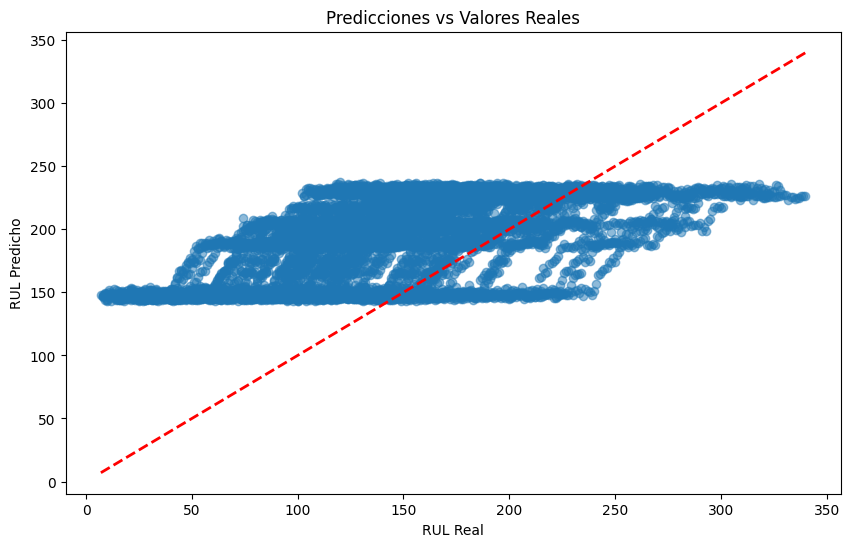

In [129]:
# Mostrar resultados
print(f"RMSE: {rmse_rf:.2f}")
print(f"R2 Score: {r2_rf:.2f}")

# Mostrar features más importantes
importance = get_feature_importance_RandomForest(model_RandomForest, X_train_rf.columns)
print("\nFeatures más importantes:")
print(importance.head(10))

# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rf, y_pred_rf, alpha=0.5)
plt.plot([y_test_rf.min(), y_test_rf.max()], [y_test_rf.min(), y_test_rf.max()], 'r--', lw=2)
plt.xlabel('RUL Real')
plt.ylabel('RUL Predicho')
plt.title('Predicciones vs Valores Reales')
plt.show()

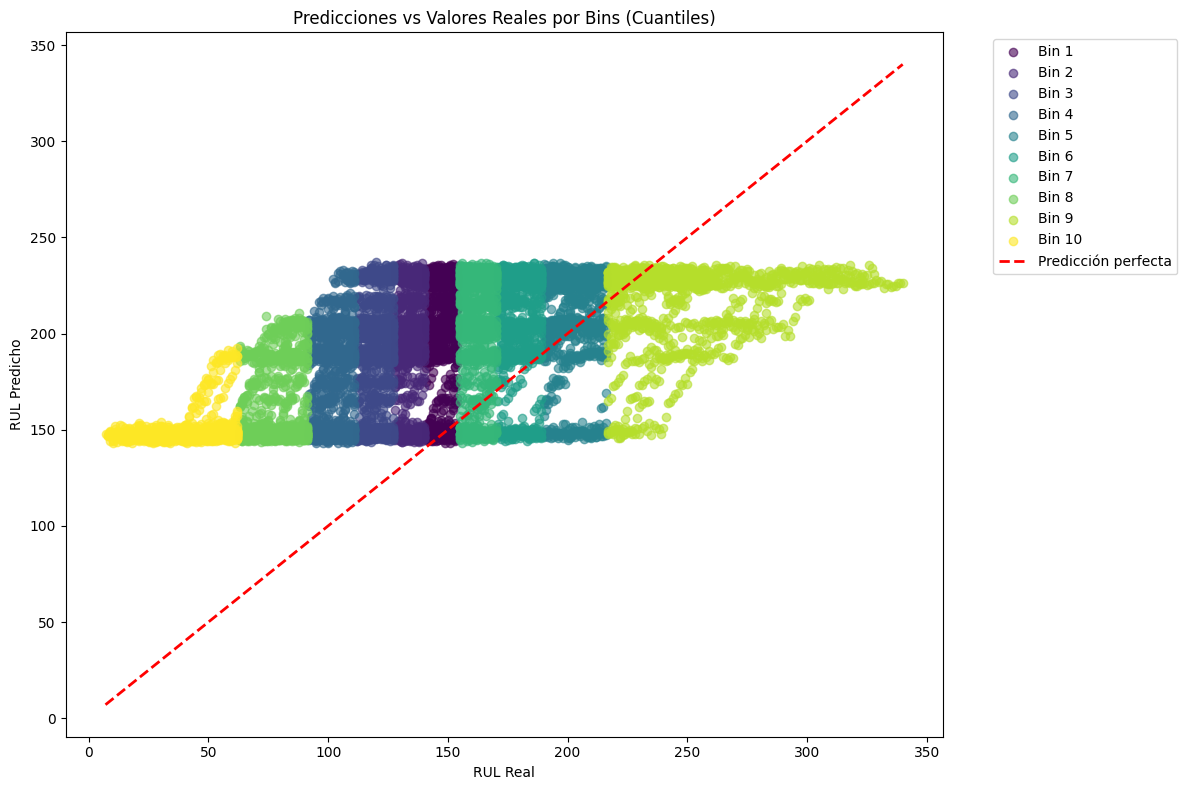

In [130]:
# Versión 1: Scatter plot con colores por bins
plt.figure(figsize=(12, 8))

# Crear bins usando qcut
bins = pd.qcut(y_test_rf, q=10, labels=['Bin '+str(i+1) for i in range(10)])
colors = plt.cm.viridis(np.linspace(0, 1, 10))

# Plotear cada bin con un color diferente
for i, (bin_name, color) in enumerate(zip(bins.unique(), colors)):
    mask = bins == bin_name
    plt.scatter(y_test_rf[mask], y_pred_rf[mask], 
               label=f'Bin {i+1}', 
               color=color, 
               alpha=0.6)

# Línea de referencia
plt.plot([y_test_rf.min(), y_test_rf.max()], 
         [y_test_rf.min(), y_test_rf.max()], 
         'r--', lw=2, 
         label='Predicción perfecta')

plt.xlabel('RUL Real')
plt.ylabel('RUL Predicho')
plt.title('Predicciones vs Valores Reales por Bins (Cuantiles)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

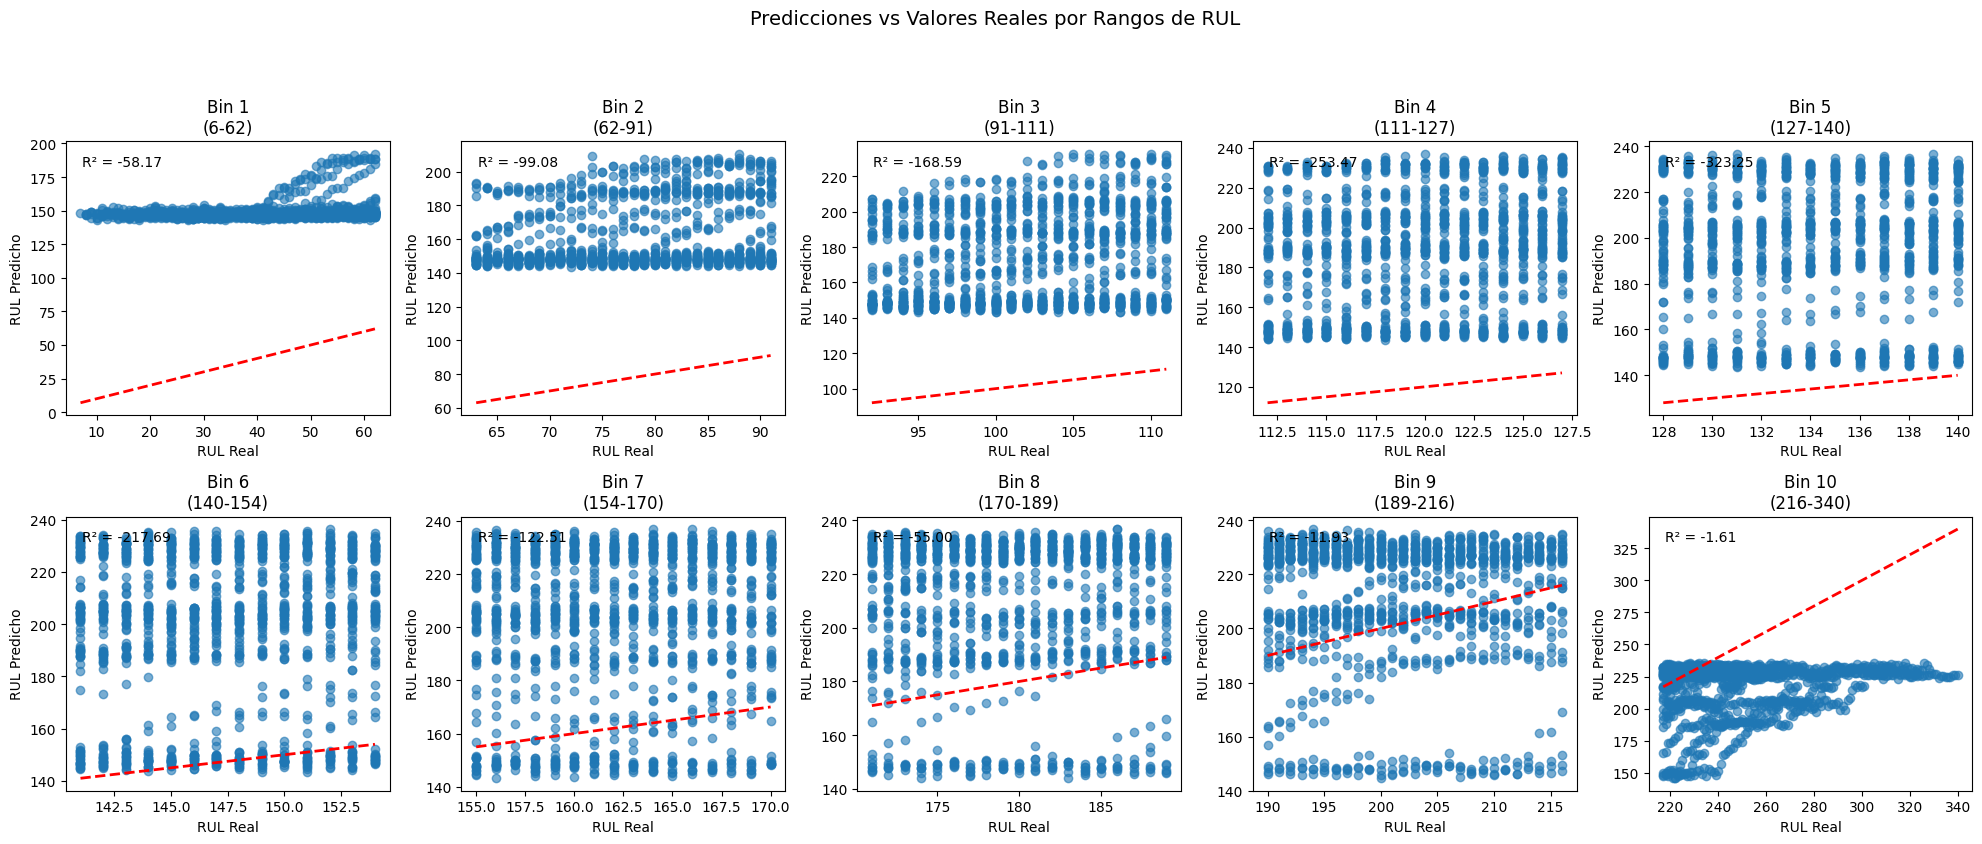


Rangos de RUL ordenados:
Bin 1: 6 - 62
Bin 2: 62 - 91
Bin 3: 91 - 111
Bin 4: 111 - 127
Bin 5: 127 - 140
Bin 6: 140 - 154
Bin 7: 154 - 170
Bin 8: 170 - 189
Bin 9: 189 - 216
Bin 10: 216 - 340


In [131]:
# Versión 2 mejorada: Subplots para cada bin ordenado
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.ravel()

# Crear bins y ordenarlos
bins = pd.qcut(y_test_rf, q=10)
unique_bins = sorted(bins.unique())  # Ordenar los bins
bin_labels = [f'Bin {i+1}\n({int(bin.left)}-{int(bin.right)})' 
              for i, bin in enumerate(unique_bins)]

# Plotear cada bin en su propio subplot
for i, (bin_name, label) in enumerate(zip(unique_bins, bin_labels)):
    mask = bins == bin_name
    axs[i].scatter(y_test_rf[mask], y_pred_rf[mask], alpha=0.6)
    axs[i].plot([y_test_rf[mask].min(), y_test_rf[mask].max()],
                [y_test_rf[mask].min(), y_test_rf[mask].max()],
                'r--', lw=2)
    
    axs[i].set_title(label)
    axs[i].set_xlabel('RUL Real')
    axs[i].set_ylabel('RUL Predicho')
    
    # Calcular R² para este bin
    r2 = r2_score(y_test_rf[mask], y_pred_rf[mask])
    axs[i].text(0.05, 0.95, f'R² = {r2:.2f}', 
                transform=axs[i].transAxes,
                verticalalignment='top')

plt.suptitle('Predicciones vs Valores Reales por Rangos de RUL', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

# Mostrar los rangos ordenados
print("\nRangos de RUL ordenados:")
for i, bin in enumerate(unique_bins, 1):
    print(f"Bin {i}: {int(bin.left)} - {int(bin.right)}")

In [132]:
# Mostrar estadísticas por bin ordenado
stats_df = pd.DataFrame({
    'Bin': range(1, 11),
    'Rango': [f'{int(bin.left)}-{int(bin.right)}' for bin in sorted(bins.unique())],
    'R²': [r2_score(y_test_rf[bins == bin], y_pred_rf[bins == bin]) for bin in sorted(bins.unique())],
    'RMSE': [np.sqrt(mean_squared_error(y_test[bins == bin], y_pred[bins == bin])) 
             for bin in sorted(bins.unique())],
    'N_muestras': [sum(bins == bin) for bin in sorted(bins.unique())]
})

# Formatear los números para mejor visualización
stats_df['R²'] = stats_df['R²'].map('{:.3f}'.format)
stats_df['RMSE'] = stats_df['RMSE'].map('{:.1f}'.format)

print("\nEstadísticas por bin (ordenados por rango de RUL):")
print(stats_df.to_string(index=False))

# Opcional: Si quieres ver qué bins tienen mejor rendimiento
stats_df_sorted = stats_df.sort_values('R²', ascending=False)
print("\nBins ordenados por mejor R²:")
print(stats_df_sorted.to_string(index=False))


Estadísticas por bin (ordenados por rango de RUL):
 Bin   Rango       R² RMSE  N_muestras
   1    6-62  -58.174 26.3        1318
   2   62-91  -99.075 33.4        1315
   3  91-111 -168.594 32.6        1328
   4 111-127 -253.472 33.5        1363
   5 127-140 -323.248 34.2        1229
   6 140-154 -217.692 32.1        1315
   7 154-170 -122.514 31.9        1340
   8 170-189  -55.001 33.9        1322
   9 189-216  -11.927 44.0        1260
  10 216-340   -1.608 81.5        1306

Bins ordenados por mejor R²:
 Bin   Rango       R² RMSE  N_muestras
   2   62-91  -99.075 33.4        1315
   1    6-62  -58.174 26.3        1318
   8 170-189  -55.001 33.9        1322
   5 127-140 -323.248 34.2        1229
   4 111-127 -253.472 33.5        1363
   6 140-154 -217.692 32.1        1315
   3  91-111 -168.594 32.6        1328
   7 154-170 -122.514 31.9        1340
   9 189-216  -11.927 44.0        1260
  10 216-340   -1.608 81.5        1306


# LSTM

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Preparar los datos igual que antes
def prepare_data_lstm(train_df, test_df, rul_df):
    # Calcular RUL para datos de entrenamiento
    train_rul = pd.DataFrame()
    for unit in train_df['unit'].unique():
        unit_data = train_df[train_df['unit'] == unit]
        max_cycle = unit_data['cycle'].max()
        unit_data['RUL'] = max_cycle - unit_data['cycle']
        train_rul = pd.concat([train_rul, unit_data])
    
    return train_rul

# 2. Preparar secuencias para LSTM
def prepare_sequences(data, sequence_length=30):
    sequences = []
    targets = []
    
    # Columnas de sensores
    sensor_cols = [f'sensor{i}' for i in range(1,22)]
    
    # Escalar los datos
    scaler = StandardScaler()
    data[sensor_cols] = scaler.fit_transform(data[sensor_cols])
    
    # Para cada motor
    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit]
        sensor_data = unit_data[sensor_cols].values
        
        # Crear secuencias
        for i in range(len(unit_data) - sequence_length):
            sequences.append(sensor_data[i:(i + sequence_length)])
            targets.append(unit_data['RUL'].iloc[i + sequence_length])
    
    return np.array(sequences), np.array(targets)

# Crear modelo LSTM
def create_lstm_model(sequence_length, n_features):
    model = Sequential([
        LSTM(128, input_shape=(sequence_length, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Predicción RUL
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [84]:
# 3. Preparar y entrenar el modelo
# Primero preparamos los datos
train_rul = prepare_data_lstm(train_df, test_df, RUL_df)


C:\Users\gurei\AppData\Local\Temp\ipykernel_8004\2023890591.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_data['RUL'] = max_cycle - unit_data['cycle']
C:\Users\gurei\AppData\Local\Temp\ipykernel_8004\2023890591.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unit_data['RUL'] = max_cycle - unit_data['cycle']
C:\Users\gurei\AppData\Local\Temp\ipykernel_8004\2023890591.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [85]:
# Luego creamos las secuencias
sequence_length = 30
X_seq, y_seq = prepare_sequences(train_rul, sequence_length)

In [86]:
# Dividir en train/validation
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [89]:
# Crear y entrenar modelo
model = create_lstm_model(sequence_length, n_features=21)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 6965.0850 - mae: 62.9486 - val_loss: 1307.5498 - val_mae: 25.1803 - learning_rate: 0.0010
Epoch 2/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 1301.8123 - mae: 24.7335 - val_loss: 981.2986 - val_mae: 21.6749 - learning_rate: 0.0010
Epoch 3/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 996.7559 - mae: 21.3910 - val_loss: 881.2400 - val_mae: 20.3527 - learning_rate: 0.0010
Epoch 4/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 878.3676 - mae: 20.1228 - val_loss: 1047.8121 - val_mae: 19.9761 - learning_rate: 0.0010
Epoch 5/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 878.6220 - mae: 20.0004 - val_loss: 719.9891 - val_mae: 18.1527 - learning_rate: 0.0010
Epoch 6/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 765.0282 - mae: 18.5149 - val_loss: 602.2712 - val_mae: 16.2564 - learning_rate: 0.0010
Epoch 7/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 667.2497 - mae: 17.4741 - val_loss

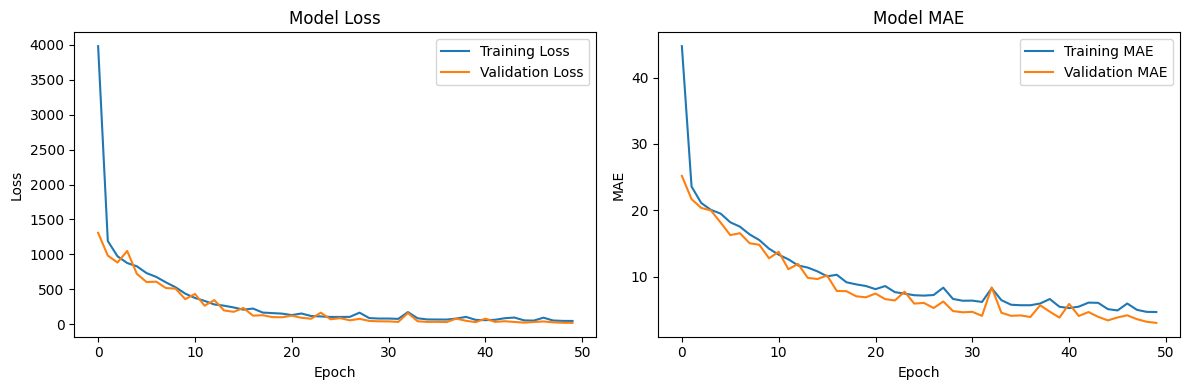

In [90]:
# 4. Visualizar el entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [91]:
# 5. Evaluar el modelo
y_pred_lstm = model.predict(X_val)
rmse_lstm = np.sqrt(mean_squared_error(y_val, y_pred_lstm))
r2_lstm = r2_score(y_val, y_pred_lstm)

print(f"\nResultados LSTM:")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R2 Score: {r2_lstm:.2f}")

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Resultados LSTM:
RMSE: 4.07
R2 Score: 1.00


In [92]:
# 1. Preparar datos de test
def prepare_test_sequences(test_df, rul_df, sequence_length=30):
    test_sequences = []
    test_targets = []
    
    sensor_cols = [f'sensor{i}' for i in range(1,22)]
    scaler = StandardScaler()
    test_df[sensor_cols] = scaler.fit_transform(test_df[sensor_cols])
    
    for unit in test_df['unit'].unique():
        unit_data = test_df[test_df['unit'] == unit]
        sensor_data = unit_data[sensor_cols].values
        true_rul = rul_df.iloc[int(unit)-1]['RUL']
        
        # Usar solo la última secuencia para cada motor
        if len(unit_data) >= sequence_length:
            sequence = sensor_data[-sequence_length:]
            test_sequences.append(sequence)
            test_targets.append(true_rul)
    
    return np.array(test_sequences), np.array(test_targets)

# 2. Evaluar en datos de test
X_test_seq, y_test_seq = prepare_test_sequences(test_df, RUL_df, sequence_length)
y_pred_test = model.predict(X_test_seq)

# 3. Calcular métricas en datos de test
rmse_test = np.sqrt(mean_squared_error(y_test_seq, y_pred_test))
r2_test = r2_score(y_test_seq, y_pred_test)

print("Resultados en datos de test:")
print(f"RMSE: {rmse_test:.2f}")
print(f"R2 Score: {r2_test:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Resultados en datos de test:
RMSE: 34.17
R2 Score: 0.32


In [93]:
# Guardar el modelo completo
model.save('../models/lstm_rul_model.h5')

In [95]:
import joblib
import os

In [96]:
try:
    # Si el scaler existe, lo guardamos
    joblib.dump(scaler, '../models/scaler.save')
    print("Scaler guardado correctamente")
except NameError:
    print("No se encontró el scaler en memoria.")
    print("Necesitamos volver a entrenar el modelo para crear")

Scaler guardado correctamente


In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

# def simulate_real_time_monitoring():
#     # Cargar el modelo y el scaler
#     model = load_model('models/lstm_rul_model.h5')
#     scaler = joblib.load('models/scaler.save')
    
#     # Configuración
#     threshold = 50  # RUL threshold para alertas (en ciclos)
#     sequence_length = 30  # Longitud de secuencia para LSTM
#     sensor_cols = [f'sensor{i}' for i in range(1,22)]
    
#     # Simular datos en tiempo real usando test_df
#     for unit in test_df['unit'].unique():
#         print(f"\nMonitoreando motor {unit}")
#         unit_data = test_df[test_df['unit'] == unit].copy()
        
#         # Buffer para mantener la secuencia de datos más reciente
#         data_buffer = []
        
#         # Simular llegada de datos en tiempo real
#         for idx, row in unit_data.iterrows():
#             # 1. Simular nuevo dato
#             current_time = datetime.now()
            
#             # Crear point para InfluxDB
#             point = Point("engine_data") \
#                 .tag("unit", f"engine_{int(row['unit'])}") \
#                 .time(current_time)
            
#             # Añadir mediciones
#             for col in sensor_cols:
#                 point.field(col, float(row[col]))
            
#             # 2. Escribir en InfluxDB
#             write_api.write(bucket="produccion_maquinas", record=point)
            
#             # 3. Actualizar buffer de datos
#             sensor_values = row[sensor_cols].values
#             data_buffer.append(sensor_values)
#             if len(data_buffer) > sequence_length:
#                 data_buffer.pop(0)
            
#             # 4. Si tenemos suficientes datos, hacer predicción
#             if len(data_buffer) == sequence_length:
#                 # Preparar datos para predicción
#                 sequence = np.array(data_buffer)
#                 sequence_scaled = scaler.transform(sequence)
#                 sequence_reshaped = sequence_scaled.reshape(1, sequence_length, len(sensor_cols))
                
#                 # Hacer predicción
#                 rul_prediction = model.predict(sequence_reshaped, verbose=0)[0][0]
                
#                 # 5. Verificar threshold y generar alerta si necesario
#                 if rul_prediction < threshold:
#                     print(f"""
#                     ⚠️ ALERTA DE MANTENIMIENTO ⚠️
#                     Motor: {unit}
#                     Tiempo: {current_time}
#                     RUL Predicho: {rul_prediction:.1f} ciclos
#                     Estado: Requiere mantenimiento pronto
#                     """)
#                 else:
#                     print(f"Motor {unit} - RUL predicho: {rul_prediction:.1f} ciclos - Estado: Normal", end='\r')
            
#             # Simular delay entre mediciones
#             time.sleep(0.1)  # 100ms entre mediciones

# # Ejecutar simulación
# try:
#     simulate_real_time_monitoring()
# except KeyboardInterrupt:
#     print("\nMonitoreo detenido por el usuario")

# # Bonus: Visualización en tiempo real
# def plot_real_time_rul(unit_predictions):
#     plt.figure(figsize=(12, 6))
#     times = list(unit_predictions.keys())
#     ruls = list(unit_predictions.values())
    
#     plt.plot(times, ruls, '-b')
#     plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
#     plt.xlabel('Tiempo')
#     plt.ylabel('RUL Predicho')
#     plt.title(f'RUL en Tiempo Real - Motor {unit}')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# Simular alerta

In [119]:
train_df.shape

(20631, 26)

In [121]:
train_df["unit"].nunique()

100

In [120]:
RUL_df.shape

(100, 1)

In [ ]:
# 2. Preparar conexión a InfluxDB
client = InfluxDBClient(
    url='http://localhost:8086',
    token="mitoken123456",
    org='miorganizacion'
)

write_api = client.write_api(write_options=SYNCHRONOUS)

In [168]:
# Cargar el modelo Random Forest y el scaler
import joblib
import json
import time

# Cargar el modelo y el scaler
rf_model = joblib.load('../models/RF_v1/model_RF_v1.joblib')
scaler = joblib.load('../models/RF_v1/scaler_RF_v1.joblib')

In [169]:
# Definir columnas de features y parámetros de InfluxDB
feature_cols = ['cycle'] + ['op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]  # Añadido 'cycle' como feature
org = "miorganizacion"  # Organización de InfluxDB 
bucket = "mn4"  # Bucket específico para este caso

# Configuración de parámetros
PREDICTION_INTERVAL = 30  # Hacer predicción cada 30 datos
threshold = 50  # Umbral de RUL para alertas

In [ ]:

def simulate_data_writing():
    # Diccionario para almacenar datos históricos por unidad
    unit_data_buffer = {}
    prediction_counter = {}
    
    # Seleccionar solo los primeros 5 motores
    first_5_units = sorted(train_df['unit'].unique())[:5]
    
    # Iterar sobre los 5 primeros motores
    for unit in first_5_units:
        unit_data = train_df[train_df['unit'] == unit].sort_values('cycle')
        prediction_counter[unit] = 0
        unit_data_buffer[unit] = []
        
        print(f"\nProcesando datos para motor {unit}")
        
        # Simular escritura de datos en tiempo real
        for idx, row in unit_data.iterrows():
            # Preparar punto de datos para InfluxDB
            point = Point("engine_measurements")\
                .tag("unit", str(unit))\
                .field("cycle", float(row['cycle']))
            
            # Agregar operaciones y mediciones de sensores
            for feature in feature_cols[1:]:  # Excluimos 'cycle' porque ya lo agregamos como tag
                point.field(feature, float(row[feature]))
            
            # Escribir a InfluxDB
            write_api.write(bucket=bucket, org=org, record=point)
            
            # Almacenar datos en buffer para predicción
            current_features = row[feature_cols].values.reshape(1, -1)  # Incluye todas las características
            unit_data_buffer[unit].append(current_features[0])
            prediction_counter[unit] += 1
            
            # Realizar predicción cada PREDICTION_INTERVAL datos
            if prediction_counter[unit] >= PREDICTION_INTERVAL:
                prediction_counter[unit] = 0
                
                # Preparar datos para predicción
                current_features_scaled = scaler.transform(current_features)
                
                # Realizar predicción con Random Forest
                rul_prediction = rf_model.predict(current_features_scaled)[0]
                
                # Verificar si se necesita generar alerta
                if rul_prediction < threshold:
                    print(f"""
                    ⚠️ ALERTA DE MANTENIMIENTO ⚠️
                    Motor: {unit}
                    Ciclo actual: {row['cycle']}
                    RUL Predicho: {rul_prediction:.1f} ciclos
                    Estado: Requiere mantenimiento pronto
                    """)
                else:
                    print(f"Motor {unit} - Ciclo {row['cycle']} - RUL predicho: {rul_prediction:.1f} ciclos - Estado: Normal")
            
            # Simular delay entre escrituras
            time.sleep(0.1)

In [146]:
# Ejecutar simulación
try:
    simulate_data_writing()
except KeyboardInterrupt:
    print("\nSimulación detenida por el usuario")


Procesando datos para motor 1


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 1 - Ciclo 30.0 - RUL predicho: 184.9 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 1 - Ciclo 60.0 - RUL predicho: 136.6 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 1 - Ciclo 90.0 - RUL predicho: 124.4 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 1 - Ciclo 120.0 - RUL predicho: 91.3 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 1 - Ciclo 150.0 - RUL predicho: 65.2 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



                    ⚠️ ALERTA DE MANTENIMIENTO ⚠️
                    Motor: 1
                    Ciclo actual: 180.0
                    RUL Predicho: 30.2 ciclos
                    Estado: Requiere mantenimiento pronto
                    

Procesando datos para motor 2


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 30.0 - RUL predicho: 200.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 60.0 - RUL predicho: 164.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 90.0 - RUL predicho: 160.4 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 120.0 - RUL predicho: 148.7 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 150.0 - RUL predicho: 140.7 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 180.0 - RUL predicho: 121.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 210.0 - RUL predicho: 113.5 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 240.0 - RUL predicho: 64.6 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



                    ⚠️ ALERTA DE MANTENIMIENTO ⚠️
                    Motor: 2
                    Ciclo actual: 270.0
                    RUL Predicho: 14.1 ciclos
                    Estado: Requiere mantenimiento pronto
                    

Procesando datos para motor 3


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 3 - Ciclo 30.0 - RUL predicho: 188.6 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 3 - Ciclo 60.0 - RUL predicho: 134.7 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 3 - Ciclo 90.0 - RUL predicho: 104.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 3 - Ciclo 120.0 - RUL predicho: 82.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



                    ⚠️ ALERTA DE MANTENIMIENTO ⚠️
                    Motor: 3
                    Ciclo actual: 150.0
                    RUL Predicho: 29.3 ciclos
                    Estado: Requiere mantenimiento pronto
                    

Procesando datos para motor 4


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 4 - Ciclo 30.0 - RUL predicho: 164.0 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 4 - Ciclo 60.0 - RUL predicho: 147.0 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 4 - Ciclo 90.0 - RUL predicho: 113.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 4 - Ciclo 120.0 - RUL predicho: 92.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



                    ⚠️ ALERTA DE MANTENIMIENTO ⚠️
                    Motor: 4
                    Ciclo actual: 150.0
                    RUL Predicho: 44.4 ciclos
                    Estado: Requiere mantenimiento pronto
                    


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



                    ⚠️ ALERTA DE MANTENIMIENTO ⚠️
                    Motor: 4
                    Ciclo actual: 180.0
                    RUL Predicho: 8.5 ciclos
                    Estado: Requiere mantenimiento pronto
                    

Procesando datos para motor 5


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 30.0 - RUL predicho: 198.4 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 60.0 - RUL predicho: 166.4 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 90.0 - RUL predicho: 153.5 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 120.0 - RUL predicho: 113.4 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 150.0 - RUL predicho: 100.7 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 180.0 - RUL predicho: 77.9 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 210.0 - RUL predicho: 54.9 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



                    ⚠️ ALERTA DE MANTENIMIENTO ⚠️
                    Motor: 5
                    Ciclo actual: 240.0
                    RUL Predicho: 25.0 ciclos
                    Estado: Requiere mantenimiento pronto
                    


In [159]:
# import smtplib
# from email.mime.text import MIMEText
# from email.mime.multipart import MIMEMultipart

# def send_alert_email(unit, cycle, rul_prediction, recipient_email="claudia.bardolet02@gmail.com"):
#     """
#     Envía un email de alerta cuando el RUL predicho está por debajo del umbral
    
#     Args:
#         unit: ID del motor
#         cycle: Ciclo actual
#         rul_prediction: Predicción de RUL
#         recipient_email: Email del destinatario
#     """
#     # Configuración del servidor SMTP para Gmail
#     smtp_server = "smtp.gmail.com"
#     smtp_port = 587
#     sender_email = "playfulbettormentor7@gmail.com"
#     password = "gqbz rhlh lgeh fkeh "  # Necesitas generar una contraseña de aplicación en tu cuenta de Google

#     # Crear mensaje
#     message = MIMEMultipart()
#     message["From"] = sender_email
#     message["To"] = recipient_email
#     message["Subject"] = f"⚠️ ALERTA DE MANTENIMIENTO - Motor {unit}"

#     # Cuerpo del mensaje
#     body = f"""
#     ALERTA DE MANTENIMIENTO PREVENTIVO
    
#     Se ha detectado que el motor {unit} necesitará mantenimiento próximamente:
    
#     - Motor: {unit}
#     - Ciclo actual: {cycle}
#     - RUL Predicho: {rul_prediction:.1f} ciclos
#     - Estado: Requiere mantenimiento pronto
    
#     Por favor, programe el mantenimiento preventivo lo antes posible.
    
#     Este es un mensaje automático generado por el sistema de monitoreo.
#     """
    
#     message.attach(MIMEText(body, "plain"))

#     try:
#         # Iniciar conexión segura
#         server = smtplib.SMTP(smtp_server, smtp_port)
#         server.starttls()
        
#         # Login
#         server.login(sender_email, password)
        
#         # Enviar email
#         server.send_message(message)
#         print(f"Email de alerta enviado para el motor {unit}")
        
#     except Exception as e:
#         print(f"Error al enviar email: {str(e)}")
    
#     finally:
#         server.quit()

# def simulate_data_writing_with_email():
#     # Diccionario para almacenar datos históricos por unidad
#     unit_data_buffer = {}
#     prediction_counter = {}
    
#     # Seleccionar solo los primeros 5 motores
#     first_1_units = sorted(train_df['unit'].unique())[:1]
    
#     # Iterar sobre los 5 primeros motores
#     for unit in first_1_units:
#         unit_data = train_df[train_df['unit'] == unit].sort_values('cycle')
#         prediction_counter[unit] = 0
#         unit_data_buffer[unit] = []
        
#         print(f"\nProcesando datos para motor {unit}")
        
#         # Simular escritura de datos en tiempo real
#         for idx, row in unit_data.iterrows():
#             # Preparar punto de datos para InfluxDB
#             point = Point("engine_measurements")\
#                 .tag("unit", str(unit))\
#                 .field("cycle", float(row['cycle']))
            
#             # Agregar operaciones y mediciones de sensores
#             for feature in feature_cols[1:]:  # Excluimos 'cycle' porque ya lo agregamos como tag
#                 point.field(feature, float(row[feature]))
            
#             # Escribir a InfluxDB
#             write_api.write(bucket=bucket, org=org, record=point)
            
#             # Almacenar datos en buffer para predicción
#             current_features = row[feature_cols].values.reshape(1, -1)
#             unit_data_buffer[unit].append(current_features[0])
#             prediction_counter[unit] += 1
            
#             # Realizar predicción cada PREDICTION_INTERVAL datos
#             if prediction_counter[unit] >= PREDICTION_INTERVAL:
#                 prediction_counter[unit] = 0
                
#                 # Preparar datos para predicción
#                 current_features_scaled = scaler.transform(current_features)
                
#                 # Realizar predicción con Random Forest
#                 rul_prediction = rf_model.predict(current_features_scaled)[0]
                
#                 # Verificar si se necesita generar alerta por email
#                 if rul_prediction < threshold:
#                     send_alert_email(unit, row['cycle'], rul_prediction)
#                 else:
#                     print(f"Motor {unit} - Ciclo {row['cycle']} - RUL predicho: {rul_prediction:.1f} ciclos - Estado: Normal")
            
#             # Simular delay entre escrituras
#             time.sleep(0.1)



In [174]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from datetime import datetime, timedelta

def send_alert_email(unit, cycle, rul_prediction, recipient_email="gureiemilian2@gmail.com"):
    """
    Envía un email de alerta cuando el RUL predicho está por debajo del umbral
    
    Args:
        unit: ID del motor
        cycle: Ciclo actual
        rul_prediction: Predicción de RUL
        recipient_email: Email del destinatario
    """
    # Configuración del servidor SMTP para Gmail
    smtp_server = "smtp.gmail.com"
    smtp_port = 587
    sender_email = "playfulbettormentor7@gmail.com"
    password = "gqbz rhlh lgeh fkeh "  # Necesitas generar una contraseña de aplicación en tu cuenta de Google

    # Crear mensaje
    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = recipient_email
    message["Subject"] = f"⚠️ ALERTA DE MANTENIMIENTO - Motor {unit}"

    # Cuerpo del mensaje
    body = f"""
    ALERTA DE MANTENIMIENTO PREVENTIVO
    
    Se ha detectado que el motor {unit} necesitará mantenimiento próximamente:
    
    - Motor: {unit}
    - Ciclo actual: {cycle}
    - RUL Predicho: {rul_prediction:.1f} ciclos
    - Estado: Requiere mantenimiento pronto
    
    Por favor, programe el mantenimiento preventivo lo antes posible.
    
    Este es un mensaje automático generado por el sistema de monitoreo.
    """
    
    message.attach(MIMEText(body, "plain"))

    try:
        # Iniciar conexión segura
        server = smtplib.SMTP(smtp_server, smtp_port)
        server.starttls()
        
        # Login
        server.login(sender_email, password)
        
        # Enviar email
        server.send_message(message)
        print(f"Email de alerta enviado para el motor {unit}")
        
    except Exception as e:
        print(f"Error al enviar email: {str(e)}")
    
    finally:
        server.quit()

def simulate_data_writing_with_email():
    # Diccionario para almacenar datos históricos por unidad
    unit_data_buffer = {}
    prediction_counter = {}
    
    # Obtener timestamp actual como punto de inicio
    current_time = datetime.now()
    
    # Seleccionar solo los primeros 5 motores
    first_1_units = sorted(train_df['unit'].unique())[:5]
    
    # Iterar sobre los 5 primeros motores
    for unit in first_1_units:
        unit_data = train_df[train_df['unit'] == unit].sort_values('cycle')
        prediction_counter[unit] = 0
        unit_data_buffer[unit] = []
        
        print(f"\nProcesando datos para motor {unit}")
        
        # Simular escritura de datos en tiempo real
        for idx, row in unit_data.iterrows():
            # Preparar punto de datos para InfluxDB con timestamp actual
            point = Point("engine_measurements")\
                .tag("unit", str(unit))\
                .field("cycle", float(row['cycle']))\
                .time(current_time)
            
            # Agregar operaciones y mediciones de sensores
            for feature in feature_cols[1:]:  # Excluimos 'cycle' porque ya lo agregamos como tag
                point.field(feature, float(row[feature]))
            
            # Escribir a InfluxDB
            write_api.write(bucket=bucket, org=org, record=point)
            
            # Almacenar datos en buffer para predicción
            current_features = row[feature_cols].values.reshape(1, -1)
            unit_data_buffer[unit].append(current_features[0])
            prediction_counter[unit] += 1
            
            # Realizar predicción cada PREDICTION_INTERVAL datos
            if prediction_counter[unit] >= PREDICTION_INTERVAL:
                prediction_counter[unit] = 0
                
                # Preparar datos para predicción
                current_features_scaled = scaler.transform(current_features)
                
                # Realizar predicción con Random Forest
                rul_prediction = rf_model.predict(current_features_scaled)[0]
                
                # Verificar si se necesita generar alerta por email
                if rul_prediction < threshold:
                    send_alert_email(unit, row['cycle'], rul_prediction)
                else:
                    print(f"Motor {unit} - Ciclo {row['cycle']} - RUL predicho: {rul_prediction:.1f} ciclos - Estado: Normal")
            
            # Incrementar el timestamp para la siguiente medición (cada 10 minutos)
            current_time += timedelta(seconds=20)
            
            # Simular delay entre escrituras
            time.sleep(0.1)


In [175]:
# Ejecutar simulación con alertas por email
try:
    simulate_data_writing_with_email()
except KeyboardInterrupt:
    print("\nSimulación detenida por el usuario")



Procesando datos para motor 1


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 1 - Ciclo 30.0 - RUL predicho: 184.9 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 1 - Ciclo 60.0 - RUL predicho: 136.6 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 1 - Ciclo 90.0 - RUL predicho: 124.4 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 1 - Ciclo 120.0 - RUL predicho: 91.3 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 1 - Ciclo 150.0 - RUL predicho: 65.2 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Email de alerta enviado para el motor 1

Procesando datos para motor 2


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 30.0 - RUL predicho: 200.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 60.0 - RUL predicho: 164.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 90.0 - RUL predicho: 160.4 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 120.0 - RUL predicho: 148.7 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 150.0 - RUL predicho: 140.7 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 180.0 - RUL predicho: 121.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 210.0 - RUL predicho: 113.5 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 2 - Ciclo 240.0 - RUL predicho: 64.6 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Email de alerta enviado para el motor 2

Procesando datos para motor 3


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 3 - Ciclo 30.0 - RUL predicho: 188.6 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 3 - Ciclo 60.0 - RUL predicho: 134.7 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 3 - Ciclo 90.0 - RUL predicho: 104.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 3 - Ciclo 120.0 - RUL predicho: 82.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Email de alerta enviado para el motor 3

Procesando datos para motor 4


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 4 - Ciclo 30.0 - RUL predicho: 164.0 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 4 - Ciclo 60.0 - RUL predicho: 147.0 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 4 - Ciclo 90.0 - RUL predicho: 113.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 4 - Ciclo 120.0 - RUL predicho: 92.8 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Email de alerta enviado para el motor 4


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Email de alerta enviado para el motor 4

Procesando datos para motor 5


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 30.0 - RUL predicho: 198.4 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 60.0 - RUL predicho: 166.4 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 90.0 - RUL predicho: 153.5 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 120.0 - RUL predicho: 113.4 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 150.0 - RUL predicho: 100.7 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 180.0 - RUL predicho: 77.9 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Motor 5 - Ciclo 210.0 - RUL predicho: 54.9 ciclos - Estado: Normal


c:\Projects\010_InfluxDB_Machine_production\InfluxDB_MachineProduction\venv_machine_prod\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Email de alerta enviado para el motor 5


In [177]:
token = "mitoken123456"

In [178]:
print(f"Bucket: {bucket}")
print(f"Org: {org}")
print(f"Token: {token}")

# Intentar escribir un dato de prueba
point = Point("test_measurement")\
    .tag("test_tag", "test")\
    .field("test_field", 1.0)

try:
    write_api.write(bucket=bucket, record=point)
    print("Dato de prueba escrito correctamente")
except Exception as e:
    print(f"Error al escribir: {str(e)}")

Bucket: mn4
Org: miorganizacion
Token: mitoken123456
Dato de prueba escrito correctamente


In [148]:

def send_alert_email(unit, cycle, rul_prediction, recipient_email="gureiemilian2@gmail.com"):
    # Configuración del servidor SMTP para Gmail
    smtp_server = "smtp.gmail.com"
    smtp_port = 587
    sender_email = "gureiemilian3@gmail.com"
    password = "tu_contraseña_de_16_caracteres"  # La contraseña que acabas de generar
    
    # ... resto del código igual ...

In [154]:
# Test simple para verificar que el envío de correo funciona
try:
    send_alert_email(
        unit=1, 
        cycle=100, 
        rul_prediction=45.5, 
        recipient_email="gureiemilian2@gmail.com"
    )
    print("Email enviado correctamente!")
except Exception as e:
    print(f"Error al enviar email: {str(e)}")

Email de alerta enviado para el motor 1
Email enviado correctamente!
